<a href="https://colab.research.google.com/github/Jitmandal051004/Rice_type_Classification/blob/main/Rice_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialization


In [31]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [32]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Pre_processing

In [33]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [34]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)
print(data_df.shape)

(18185, 11)


In [35]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [36]:
print(data_df["Class"].unique())
print(data_df["Class"].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


### Normalization

In [37]:
orig_data_df = data_df.copy()

for col in data_df.columns:
  data_df[col] = (data_df[col] / data_df[col].abs().max())

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [38]:
X = np.array(data_df.iloc[:, :-1]) #all values except last col
Y = np.array(data_df.iloc[:, -1]) #last col

print(X.shape, Y.shape)

(18185, 10) (18185,)


### Splitting of the dataset

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print(X_train.shape, X_test.shape, X_val.shape)

(12729, 10) (2728, 10) (2728, 10)


### Dataset object


In [40]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device) #vector
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [41]:
training_data = dataset(X_train, y_train)
testing_data = dataset(X_test, y_test)
validation_data = dataset(X_val, y_val)

### Data_loader


In [42]:
batch_size = 32

In [43]:
train_dataloader = DataLoader(training_data, batch_size= batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size= batch_size, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size= batch_size, shuffle=True)

In [44]:
for x, y in train_dataloader:
  print(x)
  print("========")
  print(y)
  break

tensor([[0.7805, 0.7907, 0.8616, 0.9011, 0.7489, 0.8835, 0.6980, 0.7022, 0.8680,
         0.5206],
        [0.7929, 0.8408, 0.8231, 0.9283, 0.7538, 0.8905, 0.7655, 0.7216, 0.8352,
         0.5795],
        [0.6563, 0.8888, 0.6510, 0.9764, 0.6250, 0.8101, 0.8753, 0.7068, 0.7205,
         0.7745],
        [0.5459, 0.7895, 0.6045, 0.9709, 0.5195, 0.7389, 0.9160, 0.6438, 0.7224,
         0.7409],
        [0.8902, 0.8673, 0.8942, 0.9160, 0.8487, 0.9435, 0.8888, 0.7559, 0.8545,
         0.5503],
        [0.9407, 0.8772, 0.9344, 0.9075, 0.8998, 0.9699, 0.6702, 0.7785, 0.8513,
         0.5326],
        [0.9098, 0.8799, 0.9016, 0.9175, 0.8616, 0.9538, 0.7162, 0.7586, 0.8669,
         0.5537],
        [0.8074, 0.7919, 0.8856, 0.8934, 0.7690, 0.8986, 0.7571, 0.7042, 0.8930,
         0.5073],
        [0.9474, 0.8769, 0.9320, 0.9081, 0.8924, 0.9733, 0.6692, 0.7629, 0.8928,
         0.5338],
        [0.6410, 0.8493, 0.6657, 0.9677, 0.6103, 0.8006, 0.5654, 0.6862, 0.7466,
         0.7238],
        [0

### model

In [45]:
HIDDEN_NEURONS = 10

In [46]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__() #here we will use the constructor of the nn module

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x): #define the flow of the data in the model
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)

### Create Summary


In [47]:
summary(model, (X.shape[1],)) #-1 shows batch size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Loss and Optimizer



In [48]:
criterion = nn.BCELoss() #Binary Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=1e-3)

In [49]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

epochs = 10
for epoch in range(epochs):
  total_loss_train = 0
  total_acc_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for data in train_dataloader:
    inputs, labels = data # batch size * batch size

    prediction = model(inputs).squeeze(1) #convert torch.Size([8, 1]) to torch.Size([8]) if used 1

    #loss
    batch_loss = criterion(prediction, labels) # loss after every each epoch
    total_loss_train += batch_loss.item() # after all epoch

    #accuracy
    acc = ((prediction).round() == labels).sum().item() #.item() convert tensor to main item
    total_acc_train += acc

    batch_loss.backward() #from other side
    optimizer.step() #initiate and steps optimmizer to change the weight and restart again, prevent non-convergences
    optimizer.zero_grad()

  with torch.no_grad(): #prepare the model for prediction without changing the model perimeters
    for data in validation_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)

      #loss
      batch_loss = criterion(prediction, labels)
      total_loss_val += batch_loss.item() # after all epoch

      #accuracy
      acc = ((prediction).round() == labels).sum().item() #.item() convert tensor to main item
      total_acc_val += acc
    total_loss_train_plot.append(round(total_loss_train / 1000, 4)) #round fn
    total_loss_val_plot.append(round(total_loss_val / 1000, 4)) #used to rounding

    total_acc_train_plot.append(round(total_acc_train / training_data.__len__() * 100, 4)) # training_data.__len__() --> length of the data
    total_acc_val_plot.append(round(total_acc_val / validation_data.__len__() * 100, 4))

    print(f'''Epoch no. {epoch+1}
              Train Loss: {round(total_loss_train / 1000, 4)}
              Val Loss: {round(total_loss_val / 1000, 4)}
              Train Acc: {total_acc_train_plot[-1]}
              Val Acc: {total_acc_val_plot[-1]}''') #two mtds of representing the value
    print("="*25)

Epoch no. 1 
              Train Loss: 0.2311
              Val Loss: 0.0377 
              Train Acc: 85.482 
              Val Acc: 97.654
Epoch no. 2 
              Train Loss: 0.1177
              Val Loss: 0.0164 
              Train Acc: 97.9181 
              Val Acc: 98.4238
Epoch no. 3 
              Train Loss: 0.0574
              Val Loss: 0.0094 
              Train Acc: 98.2245 
              Val Acc: 98.607
Epoch no. 4 
              Train Loss: 0.0371
              Val Loss: 0.0067 
              Train Acc: 98.3974 
              Val Acc: 98.6437
Epoch no. 5 
              Train Loss: 0.0286
              Val Loss: 0.0053 
              Train Acc: 98.4681 
              Val Acc: 98.6804
Epoch no. 6 
              Train Loss: 0.0244
              Val Loss: 0.0046 
              Train Acc: 98.4681 
              Val Acc: 98.7903
Epoch no. 7 
              Train Loss: 0.0219
              Val Loss: 0.0042 
              Train Acc: 98.5466 
              Val Acc: 98.607
Epo

### Testing Dataset


In [50]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f'''Test Loss: {round(total_loss_test / 1000, 4)}
Test Acc: {round(total_acc_test / testing_data.__len__() * 100, 4)}''')

Test Loss: 0.0036 
Test Acc: 98.8636


### Visualization

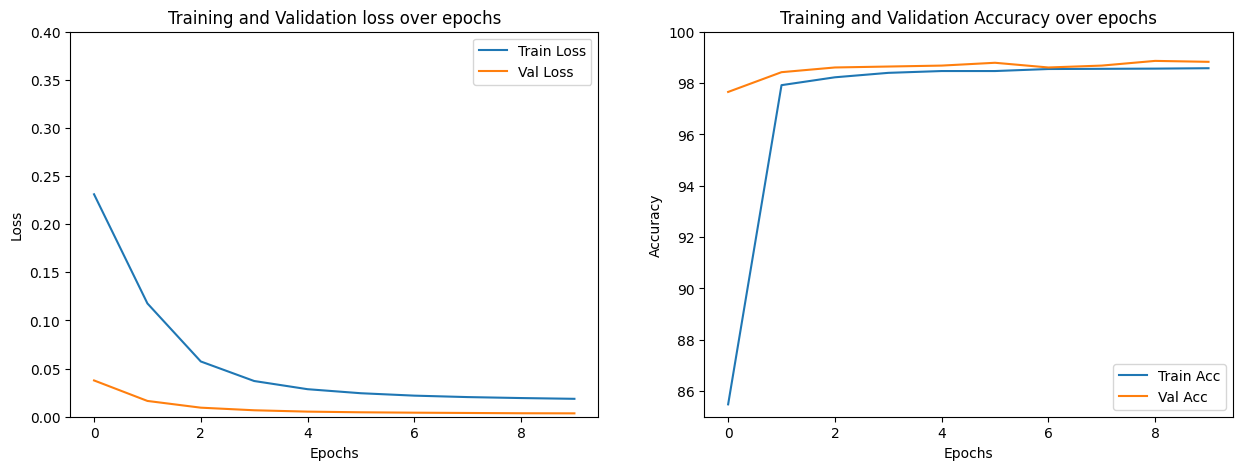

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_val_plot, label="Val Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.4])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Train Acc")
axs[1].plot(total_acc_val_plot, label="Val Acc")
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([85,100])
axs[1].legend()

plt.show()